In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import tensorflow as tf 
from tensorflow.keras import models,layers
from IPython.display import HTML

In [2]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage_2/Tomato/',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [5]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(image_batch)
    print(label_batch)

(32, 256, 256, 3)
tf.Tensor(
[[[[165. 168. 185.]
   [168. 171. 188.]
   [171. 174. 191.]
   ...
   [174. 180. 202.]
   [174. 180. 202.]
   [178. 184. 206.]]

  [[168. 171. 188.]
   [170. 173. 190.]
   [173. 176. 193.]
   ...
   [176. 182. 204.]
   [176. 182. 204.]
   [180. 186. 208.]]

  [[169. 172. 189.]
   [171. 174. 191.]
   [174. 177. 194.]
   ...
   [179. 185. 207.]
   [179. 185. 207.]
   [182. 188. 210.]]

  ...

  [[115. 112. 133.]
   [112. 109. 130.]
   [111. 108. 129.]
   ...
   [139. 141. 162.]
   [135. 137. 158.]
   [129. 131. 152.]]

  [[119. 116. 137.]
   [112. 109. 130.]
   [110. 107. 128.]
   ...
   [131. 133. 154.]
   [130. 132. 153.]
   [125. 127. 148.]]

  [[114. 111. 132.]
   [105. 102. 123.]
   [101.  98. 119.]
   ...
   [125. 127. 148.]
   [126. 128. 149.]
   [123. 125. 146.]]]


 [[[123. 109. 106.]
   [140. 126. 123.]
   [148. 134. 131.]
   ...
   [144. 127. 120.]
   [134. 117. 110.]
   [132. 115. 108.]]

  [[115. 101.  98.]
   [120. 106. 103.]
   [147. 133. 130.]

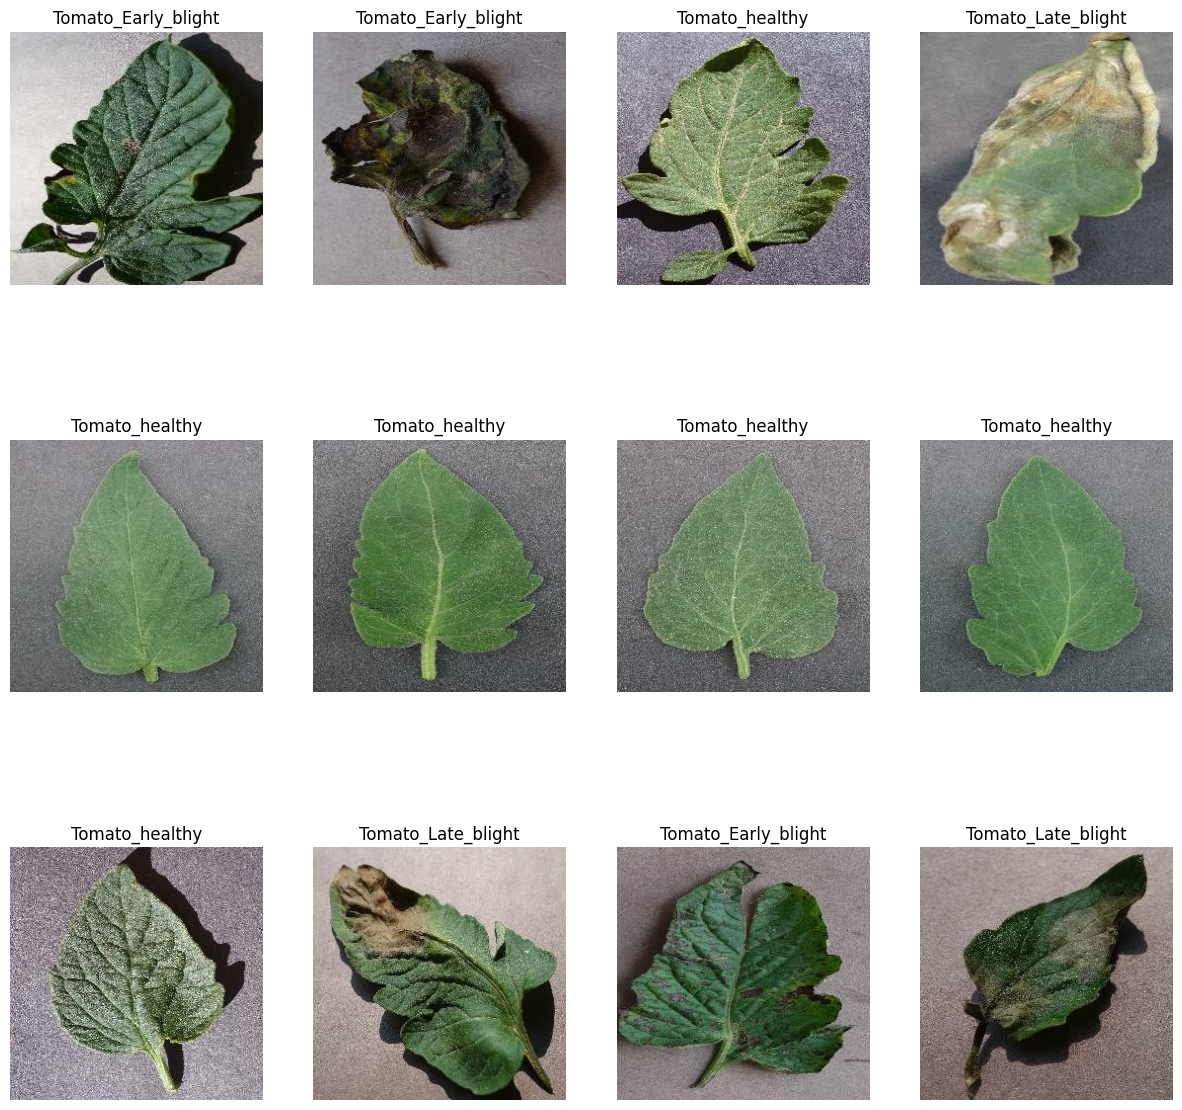

In [6]:
plt.figure(figsize=(15,15))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
plt.show()

In [7]:
len(dataset)

141

In [9]:
def get_train_partitions_df(ds,train_size=0.8,test_size=0.1,val_size=0.1,shuffle=True,shuffle_size=1000):
    assert (train_size+test_size+val_size)==1
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(ds_size*train_size)
    val_size=int(ds_size*test_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [10]:
train_ds,val_ds,test_ds=get_train_partitions_df(dataset)

In [11]:
len(train_ds)

112

In [12]:
len(test_ds)

15

In [13]:
len(val_ds)

14

In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [16]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
train_ds=train_ds.map(
    lambda x,y : (data_augmentation(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
len(train_ds)

112

In [19]:
for x, y in train_ds.take(1):
    print(x.shape, y)

(32, 256, 256, 3) tf.Tensor([2 2 1 2 0 2 1 1 2 0 1 0 0 1 0 1 1 2 1 1 1 2 1 2 0 0 2 1 2 1 1 0], shape=(32,), dtype=int32)


In [20]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [22]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [23]:
history=model.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,validation_data=val_ds,verbose=1)

Epoch 1/50
112/112 [==============================] - 38s 267ms/step - loss: 0.9048 - accuracy: 0.5470 - val_loss: 0.4818 - val_accuracy: 0.7924
Epoch 2/50
112/112 [==============================] - 26s 232ms/step - loss: 0.4486 - accuracy: 0.8175 - val_loss: 0.4864 - val_accuracy: 0.7857
Epoch 3/50
112/112 [==============================] - 26s 231ms/step - loss: 0.3319 - accuracy: 0.8581 - val_loss: 0.3878 - val_accuracy: 0.8304
Epoch 4/50
112/112 [==============================] - 26s 229ms/step - loss: 0.3063 - accuracy: 0.8681 - val_loss: 0.3654 - val_accuracy: 0.8058
Epoch 5/50
112/112 [==============================] - 24s 217ms/step - loss: 0.2828 - accuracy: 0.8768 - val_loss: 0.3668 - val_accuracy: 0.8415
Epoch 6/50
112/112 [==============================] - 24s 212ms/step - loss: 0.2823 - accuracy: 0.8819 - val_loss: 0.2025 - val_accuracy: 0.9330
Epoch 7/50
112/112 [==============================] - 25s 222ms/step - loss: 0.2386 - accuracy: 0.9015 - val_loss: 0.2037 - val_ac

In [24]:
scores=model.evaluate(test_ds)

15/15 [==============================] - 5s 42ms/step - loss: 0.0693 - accuracy: 0.9771


In [25]:
scores

[0.06927946209907532, 0.9770833253860474]

In [26]:
loss=history.history['loss']
val_loss=history.history['val_loss']
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']

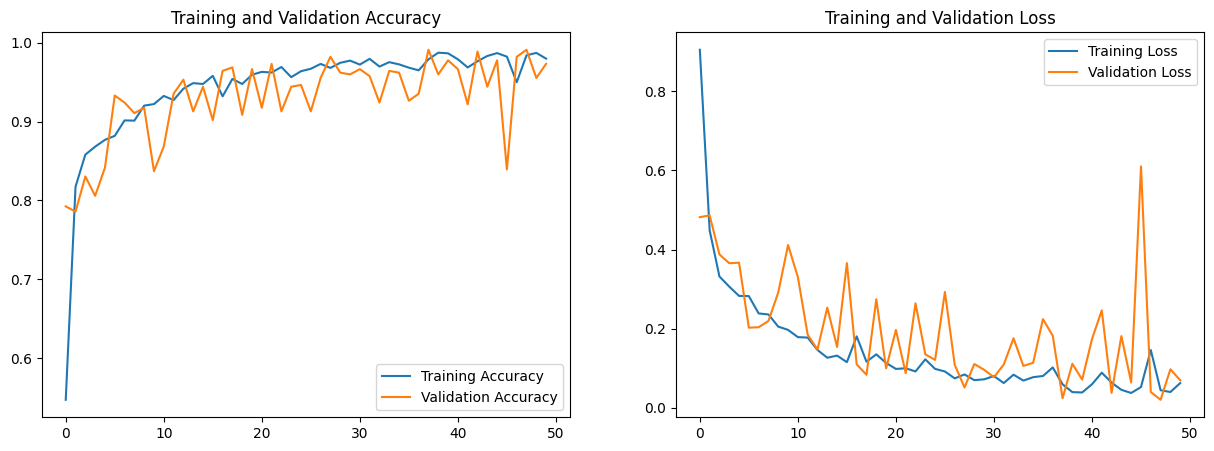

In [27]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 41ms/step


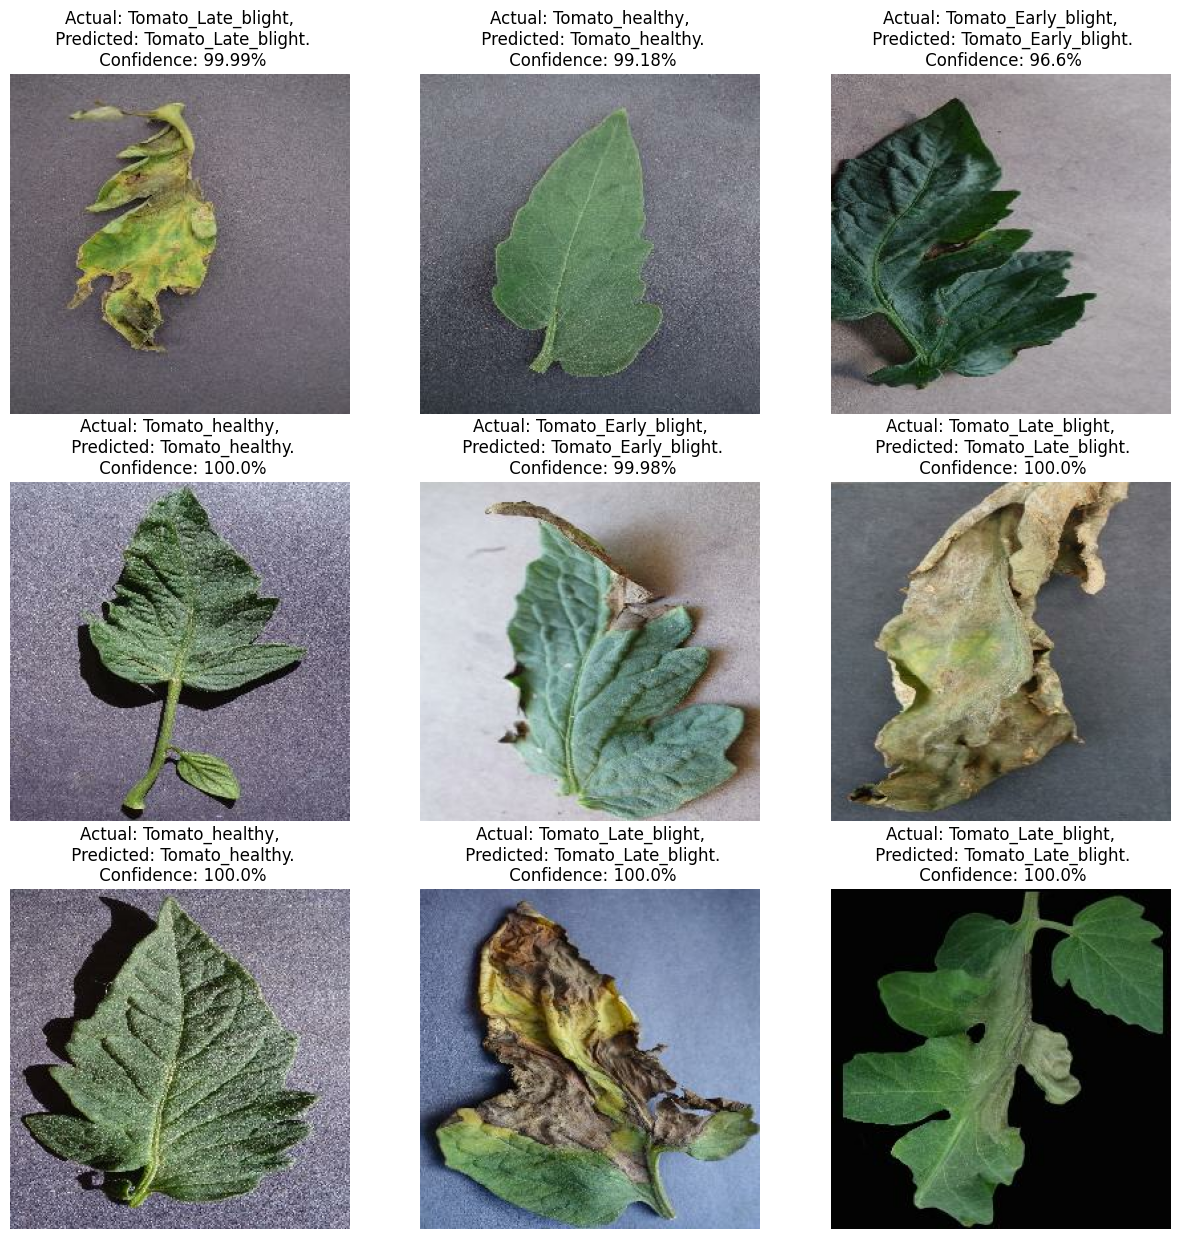

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [30]:
model_version="tomato"
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/tomato\assets


INFO:tensorflow:Assets written to: models/tomato\assets
